In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

import model


device = 'cuda'

In [22]:
root_path = os.environ.get("COMPILER2_ROOT")

In [34]:
csv_path = root_path + "/results/random-compiler2-v0/2022-04-12/19-38-46/4040330/results.csv"
print(csv_path)

/home/dx4/tools/compiler2/results/random-compiler2-v0/2022-04-12/19-38-46/4040330/results.csv


In [28]:
df = pd.read_csv(csv_path)
print(df.keys())
df['State'] = df[' State'].apply(lambda x:np.fromstring(x,sep=' '))
state_min = np.min(np.stack(df['State']),0)
state_max = np.max(np.stack(df['State']),0)
df['State'] = df['State'].apply(lambda x: (x-state_min)/(state_max-state_min+1e-9))
df['State'] = df['State'].apply(lambda x:torch.tensor(x).float())
one_hot = pd.get_dummies(df[' Action'])
df = df.join(one_hot)
df['State_'] = None
for i in range(len(df)-1):
    if str(df[' PrevActions'][i+1]) == str(df[' PrevActions'][i])+' '+str(df[' Action'][i]):
        df['State_'][i] = df['State'][i+1]
df = df.dropna()
df['Action'] = df.iloc[:,6:130].values.tolist()
df['Action'] = df['Action'].apply(lambda x: torch.tensor(x).float())
df['Reward'] = df[' Reward'].apply(lambda x: torch.tensor(x).float())
df.head()

Index(['BenchmarkName', ' PrevState', ' State', ' Action', ' PrevActions',
       ' Reward'],
      dtype='object')


,BenchmarkName,PrevState,State,Action,PrevActions,Reward,State,-adce,-add-discriminators,-aggressive-instcombine,...,-speculative-execution,-sroa,-strip,-strip-dead-prototypes,-strip-debug-declare,-strip-nondebug,-tailcallelim,State_,Action,Reward


In [29]:
class experienceDataset(Dataset):
    def __init__(self,experience):
        self.experience = experience
    def __getitem__(self, i):
        # return S,A,R,S'
        return self.experience['State'].iloc[i].to(device),self.experience['Action'].iloc[i].to(device),self.experience['Reward'].iloc[i].to(device),self.experience['State_'].iloc[i].to(device),
    def __len__(self):
        return self.experience.shape[0]

In [30]:
# class Q_net(nn.Module):
#     def __init__(self,in_size,out_size,hidden_size,dropout):
#         super(Q_net,self).__init__()
#         self.l1 = nn.Linear(in_size,hidden_size)
#         self.l2 = nn.Linear(hidden_size,hidden_size)
#         self.l3 = nn.Linear(hidden_size,hidden_size)
#         self.l4 = nn.Linear(hidden_size,hidden_size)
#         self.l5 = nn.Linear(hidden_size,hidden_size)
#         self.l6 = nn.Linear(hidden_size,hidden_size)
#         self.l7 = nn.Linear(hidden_size,out_size)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self,x):
#         x = F.leaky_relu(self.l1(x))
#         x = self.dropout(x)
#         y = F.leaky_relu(self.l2(x))
#         y = self.dropout(y)
#         x = (x+y)*0.5
#         x = F.leaky_relu(self.l3(x))
#         x = self.dropout(x)
#         y = F.leaky_relu(self.l4(x))
#         y = self.dropout(y)
#         x = (x+y)*0.5
#         x = F.leaky_relu(self.l5(x))
#         x = self.dropout(x)
#         y = F.leaky_relu(self.l6(x))
#         y = self.dropout(y)
#         x = (x+y)*0.5
#         return self.l7(x)

In [33]:
test_size = len(df) // 5
train_size = len(df) - test_size
experience = experienceDataset(df)
train_set, test_set = torch.utils.data.random_split(experience, [train_size, test_size])
batch_size = 1000
trainLoad = DataLoader(train_set,batch_size=batch_size,shuffle=True)
testLoad = DataLoader(test_set,batch_size=batch_size,shuffle=True)
policy_net = model.Q_net(28,124,512,0.5).to(device)
target_net = model.Q_net(28,124,512,0.5).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(policy_net.parameters())
train_losses = []
test_losses = []
num_epochs = 301
test_every = 5
gamma = 0.9

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [16]:
for epoch in range(num_epochs):
    loop_inner = tqdm(total=train_size//batch_size,position=0,leave=False)
    policy_net.train()
    for S,A,R,S_ in trainLoad:
        r = torch.sum(torch.mul(policy_net(S),A),1)
        r_hat = R + torch.max(target_net(S_),1).values*gamma
        
        loss = criterion(r,r_hat)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        loop_inner.set_description('epoch:{}, loss:{:.4f}'.format(epoch, loss.item()))
        loop_inner.update(1)
    loop_inner.close()
    if epoch % test_every == 0:
        with torch.no_grad():
            policy_net.eval()
            for S,A,R,S_ in trainLoad:
                r = torch.sum(torch.mul(policy_net(S),A),1)
                r_hat = R + torch.max(target_net(S_),1).values*gamma

                loss = criterion(r,r_hat)
                test_losses.append(loss.item())
    target_net.load_state_dict(policy_net.state_dict())

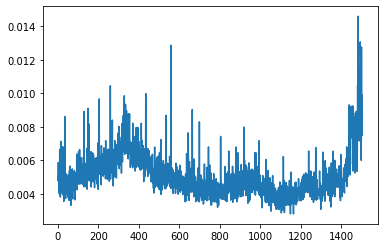

In [17]:
plt.figure(facecolor='white')
plt.plot(train_losses)

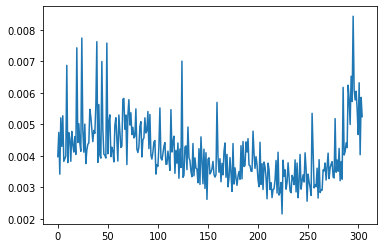

In [18]:
plt.figure(facecolor='white')
plt.plot(test_losses)

In [19]:
def get_action(state,network,epsilon):
    p = random.random()
    if p > epsilon:
        with torch.no_grad():
            return torch.max(network(state),1).indices[0].item()
    else:
        return random.randint(0,124)

In [20]:
model.get_action(df['State'].iloc[3],target_net,1)

71

In [19]:
model.get_action(df['State'].iloc[0].unsqueeze(0).to(device),target_net,0)

51